# Response Themes for "What new features or changes would you like to see in Jupyter Notebook? (Please list anything that comes to mind that helps you in your workflow, big or small.)"

* Goal: Extract theme keywords from `features_changes` responses.
* Data: Output from 2_clean_survey.ipynb notebook (`survey_short_columns.csv`)
* Process from [1_ux_survey_review.ipynb](1_ux_survey_review.ipynb):

> Moving forward, here's a semi-automatic procedure we can follow for identifying themes across questions:
> 1. Take a random sample of question responses
> 2. Write down common theme keywords
> 3. Search back through the responses using the theme keywords
> 4. Expand the set of keywords with other words seen in the search results
> 5. Repeat for all themes and questions
> Later, we can use a fully automated topic modeling approach to validate our manually generated themes.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

Make sure the samples come up the same for anyone that re-runs this.

In [4]:
rs = np.random.RandomState(123)

In [5]:
pd.set_option('max_colwidth', 1000)

In [6]:
df = pd.read_csv('survey_short_columns.csv')

In [7]:
def show(series):
    '''Make random samples easier to read.'''
    for i, value in enumerate(series):
        print('{}) {}'.format(i, value), end='\n\n')

In [8]:
responses = pd.concat([df.features_changes_1, df.features_changes_2, df.features_changes_3])

In [9]:
assert len(responses) == len(df) * 3

In [10]:
responses.isnull().value_counts()

True     3972
False    1146
dtype: int64

In [11]:
responses = responses.dropna()

## Initial Samples

I ran the sampling code below multiple times and manually built up the initial set of keywords seen commonly across them. I formed groups of conceptually related keywords. Then I tried to assign a simple label to each group.

In [12]:
show(responses.sample(20, random_state=rs))

0) sort files in folders

1) Well-documented extensions framework

2) Easy (CSS) customization of basic settings (code block themes, fonts, etc.)

3) Debug capabilities / "Workspace explorer"

4) Drag and drop for cells

5) Tighter integration of qtconsole

6) Googling for IPython notebook issues turns up tons of legacy  solutions; what's the current right way?

7) Stylesheets configuration

8) External editor

9) Allow hiding of code blocks when rendering to html/md

10) Native wrapper for saving and opening

11) https://github.com/jupyter/notebook/issues/389#issuecomment-154087320

12) Brainless cloud developement

13) Export non-code elements (Markdown and plots)

14) Built-in compatibility with git

15) Easier access to text editing

16) drag/drop of cells

17) Web API documentation

18) metadata editing within the notebook

19) small: add  So I can run jupyter as a standalone app on android with the kernel running in a chroot environment.



In [212]:
themes = {
    'ux': ['drag', 'drop', 'drag(/|&)drop', '(multiple|groups of|individual) cells', 'sections', 
           'click(ing)?', 'paste', 'undo', 'all cells', 'copy/paste', 
           'todo', '(styles?|stylesheets?|CSS|theme|skin|font|colo(u)?r)', 'scrol(ling)?', 
           'fold(ing)?(.*cells)?', 'collaps(e|ing|ible)', 'hid(e|ing|den)',
           'navigat(e|ion|ing)', 
           '(menus?|icons?|buttons?|tooltips?)', 'g?ui($|\W)', 
           'mobile', 'progress bar', 
           '(window|pane|sidebar|screen|width|height)', '(moving|reordering) cells', 'toggle',
           'spell(\s|-)?check(er|ing)?', 'dialog', ],
    'version_control': ['(source|version) (control|tracking|management)', 'git(hub)?',
                        'control version', 'not versioned', 'version-controlled', 
                        'version(ing)?(\snotebooks)?', '((version|editing) history)|revisions', 'revisions/code', 
                        'change track(er|ing)', ],
    'dissemination': ['hid(e|ing) (code|cells|input)', 'slides?', 'deployment', 'nbconvert', 'nbviewer', 
                      'dashboards?',
                      'report(ing)?', 'interact(ion|ive|ity)', 'presentations?', 'knitr', 
                      'export', 'slides(how)?', 'sharing', 'publish(ing)?', 'PDF($|\W)', 'download', 'reus(e|able)', ], 
    'documentation': ['doc(s|umentation)?($|\W)', 'tutorials?', 'instructions?', 'how(\s|-)?tos?' ],
    'ide': ['workspace|ide($|\W)|rstudio', 'variable (explorer|viewer)', 'debug', 'profil(er|ing)', 'breakpoints?', 
            'inspector', 'variables', 'pdb', ],
    'hosting': ['cloud', 'cluster', 'jupyter(\s)?hub', 'tmpnb', 'desktop', 'S3', 'backup', 'docker', 
                'install', 'hosting', 'users', 'multi(ple|-)?\s?user', ],
    'content_management': ['(folders?|director(y|ies))', 'file(\s)?system', '(toc|table of contents)', 'search', 
                           'tagging', 'file (manager|browser)', 'hierarchy', 'find\s?(\/|and\s)replace', 
                           'import(able)? (from)? notebooks?', 'import', 'refactor(ing)?', ], 
    'collab': ['collaborat(ion|ive|ing)', ],
    'editor': ['lint(ing|er)s?', '(better|powerful|external) edit(or|ing)', 
               'multi(ple\s|-)cursor', '(text|code) edit(or|ing)', 'syntax', 'diffs?($|\W)',
               'curser', 'vim?($|\W)|sublime|atom|emacs', 
               '(tab|code|auto)-?\s?complet(e|ion)', '(hot)?key(\s|-)?(mappings|bindings)', 'keyboard|short-?cuts?', 
               'parenthes(e|i)s', ],
    'integration': ['integrat(e|ion)', '(apache\s)?spark', 'pydb', 'matplotlib', 'django', 
                    'pandoc', 'wordpress', 'pyflakes', 'third-party', 'packages', ],
    'visualization': ['d3', 'widgets', 'visualization', 'plotting', 'graphics', ],
    'cranky': ['dial down the hype', ], 
    'performance': ['performance', 'more speed', 'cach(e|ing)', ],
    'compatibility': ['communication of changes', 'package updates', 'compatib(ility|le)', ],
    'language': ['python', 'language', 'clojure', 'fortran', 'javascript', 'R($|\W)', 'C\/C', ],
    'cli': ['cli($|\W)', 'terminal', 'command line', 'console', ],
}

## Coverage Improvement

I next ran the code below to associate the theme labels with the responses. I then iterated on running the code below to find reponses without labels. I expanded the list of keywords and themes above in order to improve coverage.

In [213]:
import re

In [214]:
def keywords_or(text, keywords):
    for keyword in keywords:
        if re.search('(^|\W+){}'.format(keyword), text, re.IGNORECASE):
            return True
    return False

In [215]:
def tag_themes(responses, themes):
    tagged = responses.to_frame()
    tagged['themes'] = ''
    for theme, keywords in themes.items():
        results = responses.map(lambda text: keywords_or(text, keywords))
        tagged.loc[results, 'themes'] += theme + ','
        print(theme, results.sum())
    return tagged

In [216]:
tagged = tag_themes(responses, themes)
tagged.themes.str.count(',').value_counts()

language 55
ux 267
cli 23
documentation 32
integration 126
ide 102
editor 128
version_control 106
dissemination 112
performance 5
content_management 67
compatibility 5
collab 23
hosting 63
visualization 48
cranky 1


1    659
0    257
2    192
3     33
4      4
5      1
Name: themes, dtype: int64

In [217]:
tagged[tagged.themes.str.len() == 0].sample(20, random_state=rs)

,0,themes
627,visualisation of variable contents,
53,get rid of server as something user-facing,
1355,"The ability to run individual lines of code, instead of the entire cell",
48,Attaching notebook to running kernel,
1524,Easier to learn,
338,Easier multi-cell selection and editing within and between notebooks,
61,automatic cleanup of un-closed notebooks which are using a lot of memory/better RAM management in general,
107,Separate application,
95,Easier way to see execution order of cells which have run out of order sometimes,
298,connecting to database servers,


## Precision Check

I then studied a sample of responses for each theme to see if there major inaccuracies in their application (e.g., string matches that are too fuzzy).

In [218]:
tagged = tag_themes(responses, themes)
tagged.themes.str.count(',').value_counts()

language 55
ux 267
cli 23
documentation 32
integration 126
ide 102
editor 128
version_control 106
dissemination 112
performance 5
content_management 67
compatibility 5
collab 23
hosting 63
visualization 48
cranky 1


1    659
0    257
2    192
3     33
4      4
5      1
Name: themes, dtype: int64

In [219]:
from IPython.display import display, clear_output

In [229]:
# for key in themes:
#     clear_output()
#     size = min([10, len(tagged[tagged.themes.str.contains(key)])])
#     display(tagged[tagged.themes.str.contains(key)].sample(size))
#     if input('Showing `{}`. Type Enter to continue, "q" to stop.'.format(key)) == 'q':
#         break

I also looked at responses with multiple themes to fine tune them, and catch duplication of words in multiple themes.

In [230]:
tagged[tagged.themes.str.count(',') == 2].sample(20, random_state=rs)

,0,themes
1604,Better tutorials for setting up eg jupyterhub and tmpnb,"documentation,hosting,"
439,Integrated debugging,"integration,ide,"
535,"Editor window for larger amounts of code, with a notebook that uses the same environment variables. Basically, a really large cell on the left of the screen for functions and supporting code.","ux,ide,"
1343,Different languages for code cells inside the same notebook,"language,ide,"
594,hints on keyboard shortcuts in menus,"ux,editor,"
167,Awesome deployable interaction widgets,"dissemination,visualization,"
587,Git integration,"integration,version_control,"
145,"Repeating Q7 #2 here: When I do an analysis, I may delete a cell (which I thought was extra) - I rerun the notebook at it works fine because the variables from the deleted cell are still in the name space (but I don't notice that) so when I re-open the notebook the next day to rerun the analysis it doesn't work - and it is too late to restore that deleted cell. This may just be a personal problem and I need to be more organized, but it has happened a few times so I thought I would mention it - if when you delete a cell that has variables declared in it - then it drops those values when the cell is deleted rather than keep them in namespace. Again, I am not sure of the implications of that on other areas of the notebook functionality.","ux,ide,"
135,Easy to reconfigure keyboard shortcuts (through a GUI),"ux,editor,"
1234,Integration with cloud env,"integration,hosting,"


## Keyword Frequencies

In [231]:
import matplotlib
import seaborn

In [232]:
counts = {}

In [233]:
for theme, keywords in themes.items():
    for keyword in keywords:
        hits = responses.map(lambda text: keywords_or(text, [keyword]))
        counts[keyword] = hits.sum()

In [234]:
hist = pd.Series(counts).sort_values()

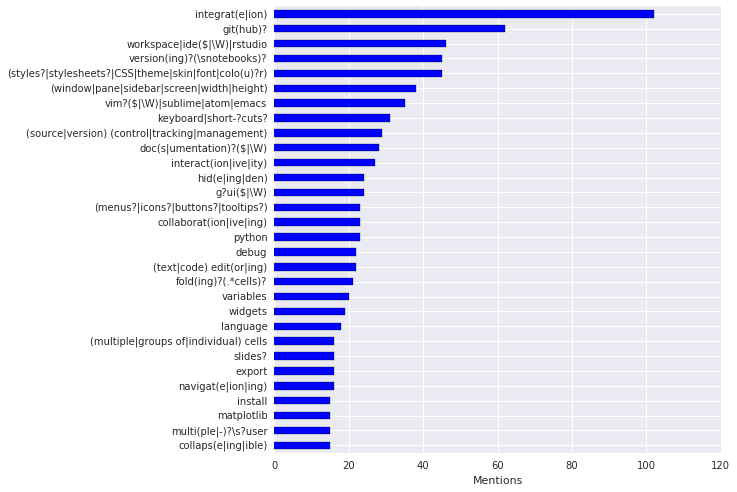

In [235]:
ax = hist[-30:].plot.barh(figsize=(8, 8))
_ = ax.set_xlabel('Mentions')

## Persist

I save off the themes and keywords to a DataFrame with the same index as the original so that the entries can be tagged.

In [236]:
column = 'features_changes'

In [237]:
themes_df = tagged.themes.to_frame()

In [238]:
themes_df = themes_df.rename(columns={'themes' : column+'_themes'})

In [239]:
themes_df[column+'_keywords'] = ''

In [240]:
for theme, keywords in themes.items():
    for keyword in keywords:
        results = responses.map(lambda text: keywords_or(text, [keyword]))
        if not results.sum(): continue
        themes_df.loc[results, column+'_keywords'] += keyword + ','

In [241]:
themes_df[column+'_themes'] = themes_df[column+'_themes'].str.rstrip(',')
themes_df[column+'_keywords'] = themes_df[column+'_keywords'].str.rstrip(',')

Up above, I merged the three response fields for the question into one common pool which means we can have duplicate index value in the themes DataFrame. We need to squash these down and remove duplicates.

In [242]:
def union(group_df):
    '''Gets the set union of themes and keywords for a given DataFrame.'''
    themes = group_df[column+'_themes'].str.cat(sep=',')
    themes = list(set(themes.split(',')))
    themes = ','.join(themes)
    
    keywords = group_df[column+'_keywords'].str.cat(sep=',')
    keywords = list(set(keywords.split(',')))
    keywords = ','.join(keywords)
    return pd.Series([themes, keywords], index=[column+'_themes', column+'_keywords'])

We group by the index and union the themes and keywords.

In [243]:
themes_df = themes_df.groupby(themes_df.index).apply(union)

In [244]:
themes_df.head()

,features_changes_themes,features_changes_keywords
1,"editor,cli,version_control","diffs?($|\W),git(hub)?,command line"
5,"integration,ide,visualization,cli,dissemination","workspace|ide($|\W)|rstudio,variables,terminal,graphics,matplotlib,interact(ion|ive|ity)"
6,"hosting,documentation,dissemination","download,slides(how)?,doc(s|umentation)?($|\W),nbconvert,slides?,PDF($|\W),jupyter(\s)?hub"
7,dissemination,"report(ing)?,knitr,dashboards?"
9,,


The themes DataFrame should have as many rows as there are non-null responses in the original DataFrame.

In [245]:
assert len(themes_df) == len(df[[column+'_1', column+'_2', column+'_3']].dropna(how='all'))

In [246]:
themes_df.to_csv(column + '_themes.csv', sep=';')